In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [3]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        beta_mean = 1.0*torch.ones((50,len(layers)-2))
        beta_std = 0.1*torch.ones((50,len(layers)-2))
        
        self.beta = Parameter(torch.normal(beta_mean,beta_std))
        self.beta.requiresGrad = True
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xt).float().to(device)
        lbxy = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta[:,i]*z*z1
       
            
        a = self.linears[-1](a) 
         
        return a
    
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        

            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xt).float().to(device)
        lbxy = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a =self.activation(z)
       
            
        a = self.linears[-1](a) 
         
        return a

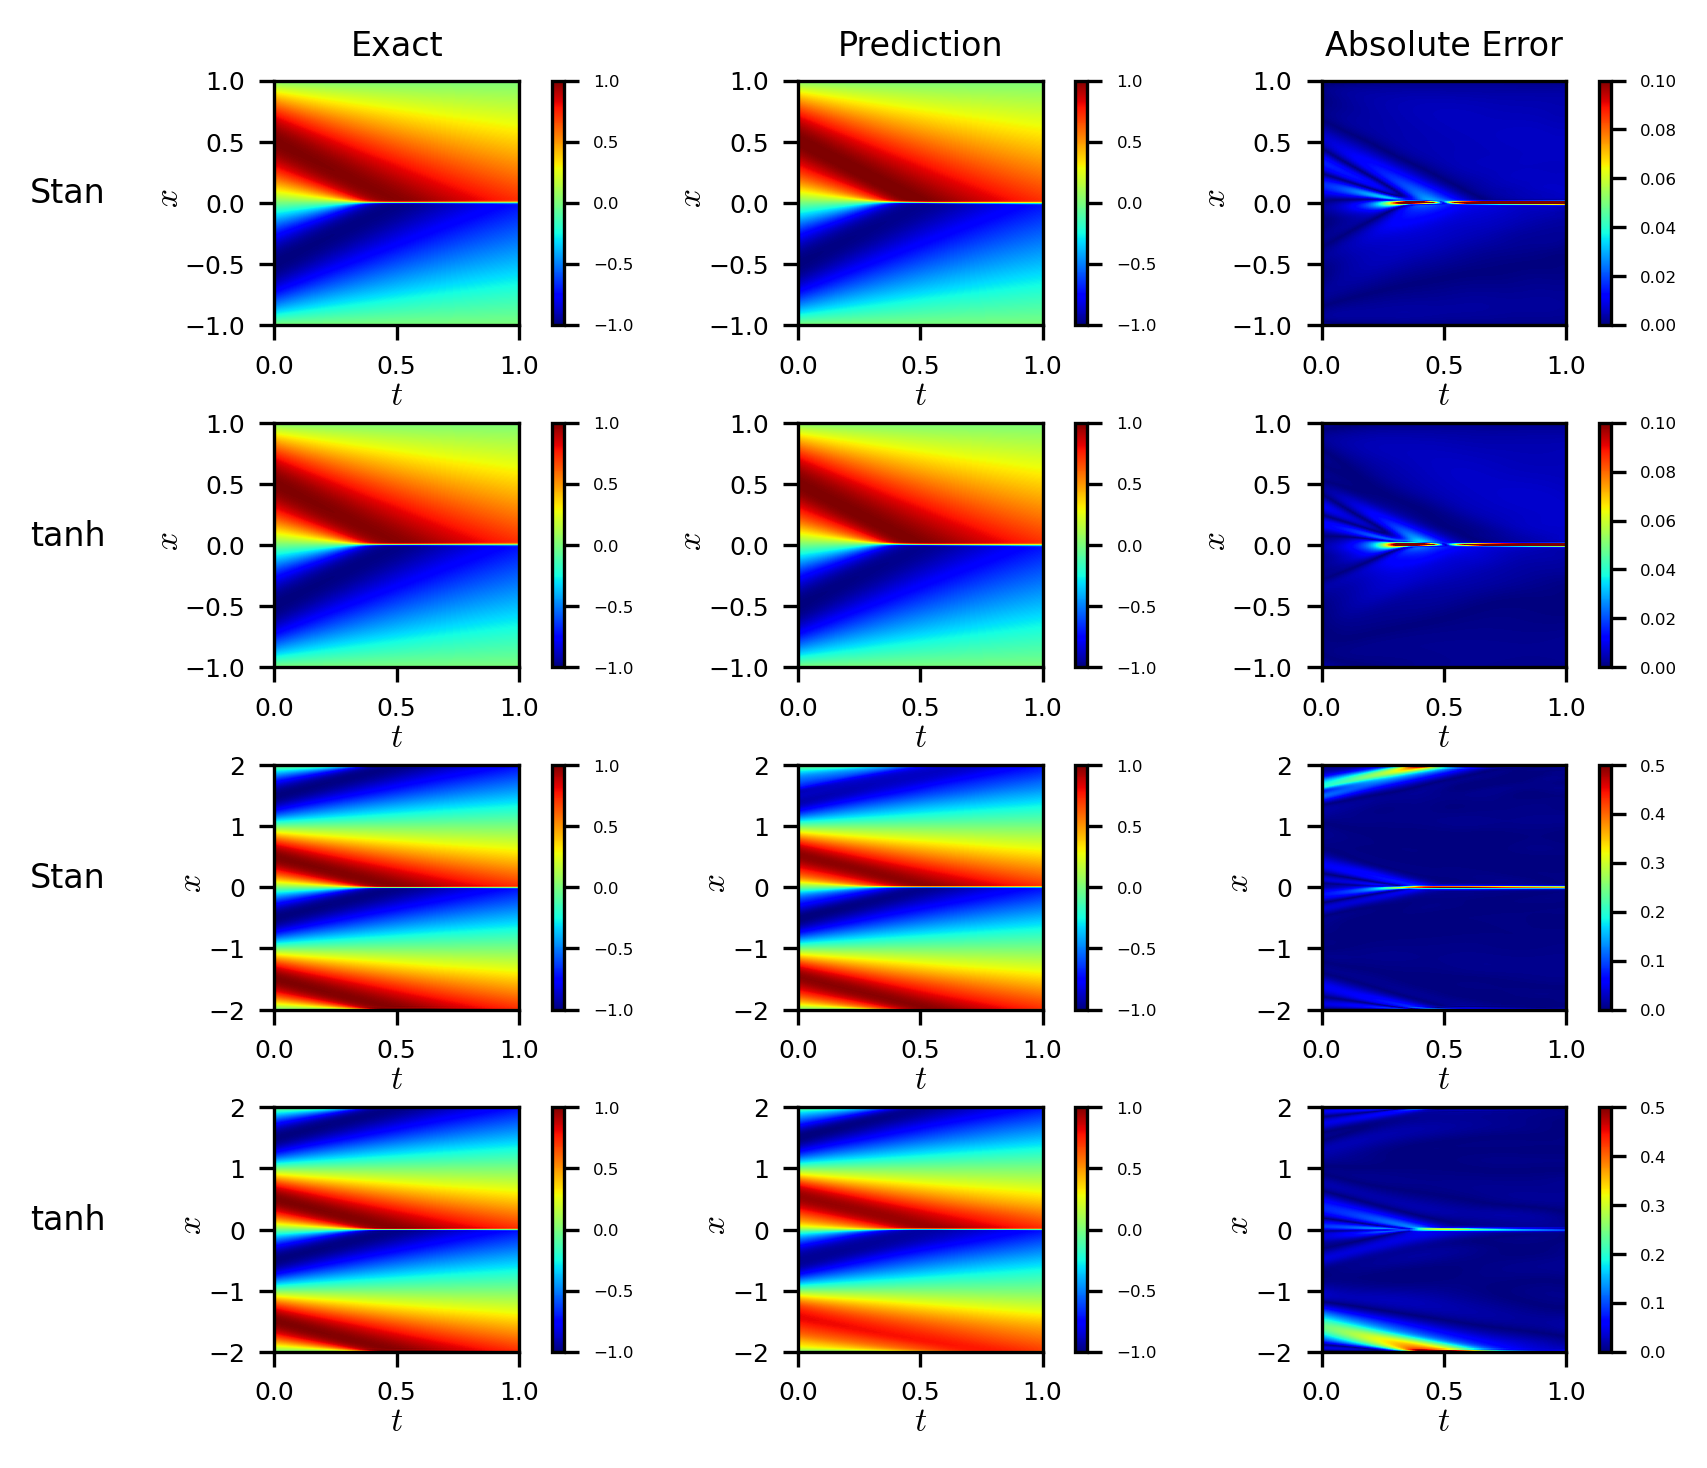

In [65]:
fig, axs = plt.subplots(4,3)
cmap = plt.cm.jet

level_ind = 0

levels = ["low","high"]
level = levels[level_ind]
extent=[0,1,-1,1]

rep_num = 0

data = scipy.io.loadmat('burgers_shock.mat') 

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

x = np.array(data['x'])
t = np.array(data['t'])

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))
lb_xt = xt[0]
ub_xt = xt[-1]

u_true = np.array(data['usol'][:]).reshape(-1,1)

xt_test_tensor = torch.from_numpy(xt).float().to(device)


fig.dpi=300
fig.tight_layout()

layers = np.array([2,50,50,50,50,50,1]) #9 hidden layers

algo_names = ['stan','tanh']
prob_name = "Burgers_"
# plt_titles = ['Stan (Proposed)','tanh']


rowdy_terms = 2

PINNs = [Sequentialmodel_stan(layers),Sequentialmodel_tanh(layers)] 


for i in range(2):
    PINNs[i].load_state_dict(torch.load(prob_name + algo_names[i] + '_' + level+'_'+str(rep_num)+'.pt'))

    u_pred = PINNs[i].forward(xt_test_tensor).cpu().detach().numpy()
    
    img = axs[i,0].imshow(u_true.reshape(256,100),vmin = -1,vmax = 1,cmap = cmap,extent=extent,aspect = 0.5) 
    cbar = fig.colorbar(img, ax=axs[i,0])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
    
    img = axs[i,1].imshow(u_pred.reshape(256,100),vmin = -1,vmax = 1,cmap = cmap,extent=extent,aspect = 0.5) 
    cbar = fig.colorbar(img, ax=axs[i,1])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 

    
    img = axs[i,2].imshow(np.abs(u_pred-u_true).reshape(256,100),vmin = 0,vmax = 0.1,cmap = cmap,extent=extent,aspect = 0.5)
    cbar = fig.colorbar(img, ax=axs[i,2])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
    
    
    for j in range(3):
        axs[i,j].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.0)
        axs[i,j].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.0)
        axs[i,j].tick_params(labelsize=6)
#--------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

level_ind = 1

levels = ["low","high"]
level = levels[level_ind]
extent=[0,1,-2,2]

rep_num = 0

data = scipy.io.loadmat('burgers_double.mat') 

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

x = np.array(data['x'])
t = np.array(data['t'])

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))
lb_xt = xt[0]
ub_xt = xt[-1]

u_true = np.array(data['usol'][:]).reshape(-1,1)

xt_test_tensor = torch.from_numpy(xt).float().to(device)


fig.dpi=300
fig.tight_layout()

layers = np.array([2,50,50,50,50,50,50,50,1]) #9 hidden layers

algo_names = ['stan','tanh']
prob_name = "Burgers_"

rowdy_terms = 2

PINNs = [Sequentialmodel_stan(layers),Sequentialmodel_tanh(layers)] 


for i in range(2):
    PINNs[i].load_state_dict(torch.load(prob_name + algo_names[i] + '_' + level+'_'+str(rep_num)+'.pt'))

    u_pred = PINNs[i].forward(xt_test_tensor).cpu().detach().numpy()
    
    img = axs[i+2,0].imshow(u_true.reshape(256,100),vmin = -1,vmax = 1,cmap = cmap,extent=extent,aspect =0.25)
    cbar = fig.colorbar(img, ax=axs[i+2,0])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
    img =axs[i+2,1].imshow(u_pred.reshape(256,100),vmin = -1,vmax = 1,cmap = cmap,extent=extent,aspect = 0.25)    
    cbar = fig.colorbar(img, ax=axs[i+2,1])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
    img = axs[i+2,2].imshow(np.abs(u_pred-u_true).reshape(256,100),vmin = 0,vmax = 0.5,cmap = cmap,extent=extent,aspect = 0.25)
    cbar = fig.colorbar(img, ax=axs[i+2,2])
    cbar.ax.tick_params(labelsize=4,labelbottom = True,labeltop = False, bottom =True, top = False) 
    
    for j in range(3):
        axs[i+2,j].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.0)
        axs[i+2,j].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.0)
        axs[i+2,j].tick_params(labelsize=6)
    
plt_titles = ["Exact","Prediction","Absolute Error"]   
for i in range(3):
    axs[0,i].set_title(plt_titles[i],fontsize=8, math_fontfamily='cm')    
    
plot_rows = ['Stan','tanh','Stan','tanh']

for i in range(4):
    axs[i,0].text(-1.0,0.5,plot_rows[i],fontsize=8,transform=axs[i,0].transAxes)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.2, hspace=0.4)
plt.savefig('Burgers_figure.pdf', format='pdf',pad_inches=0, bbox_inches='tight')